In [1]:
import os
os.chdir('../')

In [2]:
import datetime

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset
import albumentations as A

from src.datasets.transforms import get_train_transform
from src.configs import cfg
pd.options.display.max_rows = 1000

In [16]:
def to_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str): return eval(x)

class PreprocessDataset(Dataset):
    def __init__(self, cfg, df, transform = None):
        self.df = df
        self.cfg = cfg
        self.transform = transform
        self.length = len(df)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        image = np.zeros(
            (self.cfg.INPUT.IMG_HEIGHT,self.cfg.INPUT.IMG_WIDTH), 
            np.uint8
        )

        img_path = os.path.join(
            self.cfg.INPUT.ROOT_DIR,
            'bc_1280_train_lut',
            f"{str(d['patient_id'])}_{str(d['image_id'])}.png"
        )

        m = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        h, w = m.shape

        try: #for degenerate case
            xmin, ymin, xmax, ymax = (np.array(to_list(d.pad_breast_box)) * h).astype(int)
            crop = m[ymin:ymax, xmin:xmax]

            mh, mw = (np.array(to_list(d.max_pad_breast_shape)) * h).astype(int)
            scale = min(self.cfg.INPUT.IMG_HEIGHT/mh,  self.cfg.INPUT.IMG_WIDTH/mw)
            dsize = (min(self.cfg.INPUT.IMG_WIDTH, int(scale * crop.shape[1])), min(self.cfg.INPUT.IMG_HEIGHT, int(scale * crop.shape[0])))
            if dsize != (crop.shape[1], crop.shape[0]):
                crop = cv2.resize(crop, dsize=dsize, interpolation=cv2.INTER_LINEAR)
            ch,cw = crop.shape  
            x = (self.cfg.INPUT.IMG_WIDTH  - cw) // 2
            y = (self.cfg.INPUT.IMG_HEIGHT - ch) // 2
            image[y:y + ch, x:x + cw] = crop

        except:
            crop  = m
            scale = min(self.cfg.INPUT.IMG_HEIGHT / h, self.cfg.INPUT.IMG_WIDTH / w)
            dsize = (min(self.cfg.INPUT.IMG_WIDTH, int(scale * crop.shape[1])), min(self.cfg.INPUT.IMG_HEIGHT, int(scale * crop.shape[0])))
            if dsize != (crop.shape[1], crop.shape[0]):
                crop = cv2.resize(crop, dsize=dsize, interpolation=cv2.INTER_LINEAR)
            ch, cw = crop.shape
            x = (self.cfg.INPUT.IMG_WIDTH  - cw) // 2
            y = (self.cfg.INPUT.IMG_HEIGHT - ch) // 2
            image[y:y + ch, x:x + cw] = crop
            

        if self.transform:
            image = self.transform(image=image)
        
        label = d['cancer']
        img_meta = {
            'img_id': d['image_id'],
            'patient_id': d['patient_id'],
            'laterality': d['laterality'],
            'site_id': d['site_id']
        }

        aux_target = d[self.cfg.INPUT.AUX_TARGETS].to_numpy(dtype=int)
        
        return image['image'], label, aux_target, img_meta


In [17]:
train = pd.read_csv(
    cfg.INPUT.ROOT_DIR+'/train_folds.csv'
)

trns = get_train_transform(cfg)

ds = PreprocessDataset(df = train, cfg=cfg, transform=trns)

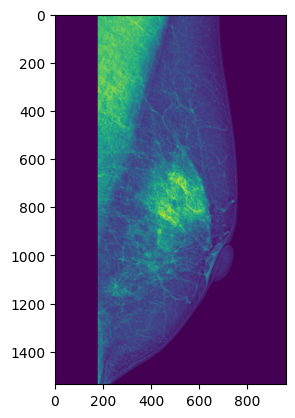

In [10]:
img = ds[1]['image'].detach().cpu().numpy()
plt.imshow(img.squeeze())

In [5]:
train[train['patient_id'] == 5]

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold
37282,37282,1,5,640805896,0,5,8,0,0,0,0.0,0,NaN,0,True,1
37283,37283,1,5,1351088028,0,1,8,0,0,0,0.0,0,NaN,0,True,1
37284,37284,1,5,940388076,1,1,8,0,0,0,NaN,0,NaN,0,False,1
37285,37285,1,5,1633417959,1,5,8,0,0,0,NaN,0,NaN,0,False,1


In [6]:
train.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold
0,0,1,10006,462822612,0,1,5,0,0,0,NaN,0,NaN,1,False,4
1,1,1,10006,1459541791,0,5,5,0,0,0,NaN,0,NaN,1,False,4
2,2,1,10006,1864590858,1,5,5,0,0,0,NaN,0,NaN,1,False,4
3,3,1,10006,1874946579,1,1,5,0,0,0,NaN,0,NaN,1,False,4
4,4,1,10011,220375232,0,1,3,0,0,0,0.0,0,NaN,0,True,3


In [7]:
train['site_id'].value_counts()

0    29519
1    25187
Name: site_id, dtype: int64

In [8]:
train['patient_id'].nunique()

11913

In [9]:
train['cancer'].value_counts(normalize=True)

0    0.978832
1    0.021168
Name: cancer, dtype: float64

In [10]:
patient_positive = train[train['cancer'] == 1]['patient_id']
train[train['patient_id'].isin(patient_positive)]


,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold
87,87,0,10130,388811999,0,5,8,1,1,1,0.0,0,B,3,False,4
88,88,0,10130,613462606,0,1,8,1,1,1,0.0,0,B,3,False,4
89,89,0,10130,1360338805,0,1,8,1,1,1,0.0,0,B,3,False,4
90,90,0,10130,1672636630,0,5,8,1,1,1,0.0,0,B,3,False,4
91,91,0,10130,1013166704,1,1,8,0,0,0,NaN,0,B,3,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54594,54594,1,9840,1559360810,1,1,4,1,1,1,NaN,0,NaN,0,False,2
54595,54595,1,9851,1409270544,0,5,4,1,1,0,NaN,0,NaN,2,False,4
54596,54596,1,9851,1434430689,0,1,4,1,1,0,NaN,0,NaN,2,False,4
54597,54597,1,9851,446210671,1,1,4,0,0,0,NaN,0,NaN,2,False,4


In [12]:
img = cv2.imread(
    os.path.join(
        cfg.INPUT.ROOT_DIR,
        'bc_1280_train_lut',
        '65534_44480502.png'
    )
)

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [12]:
from src.datasets.builder import create_train_loader, create_valid_loader
train_loader = create_train_loader(
    cfg=cfg,
    df=train.sample(n=100)
)

valid_loader = create_valid_loader(
    cfg=cfg,
    df=train[train['fold']==cfg.INPUT.VALID_FOLD]
)

In [13]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [14]:
for step, (images, targets, image_ids, patinet_id) in enumerate(train_loader):
    print(images.shape)

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


In [15]:
import timm

model = timm.create_model(
    'seresnext50_32x4d', 
    pretrained=True,
    in_chans=1,
    num_classes=0
)

In [16]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'seresnext50_32x4d'}

In [17]:
list(model.parameters())[-1].shape[0]

2048

In [18]:
from src.modeling.model import kaggleBCModel
model = kaggleBCModel(cfg)

In [19]:
model(images.float())

tensor([[-0.0233],
        [-0.0163],
        [ 0.0068],
        [ 0.1056],
        [-0.0091],
        [ 0.1641],
        [ 0.1197],
        [ 0.0684],
        [ 0.0981],
        [ 0.0851],
        [ 0.0504],
        [ 0.1505],
        [ 0.0489],
        [ 0.0647],
        [-0.0205],
        [-0.1103],
        [ 0.2498],
        [ 0.0004],
        [ 0.0823],
        [ 0.0215],
        [ 0.1745],
        [ 0.0159],
        [ 0.1087],
        [-0.0299],
        [ 0.1218],
        [ 0.1515],
        [ 0.0059],
        [ 0.1271],
        [ 0.0806],
        [ 0.0487],
        [-0.0486],
        [ 0.0408]], grad_fn=<AddmmBackward0>)

In [20]:
torch.sigmoid(model(images.float()))

tensor([[0.4942],
        [0.4959],
        [0.5017],
        [0.5264],
        [0.4977],
        [0.5409],
        [0.5299],
        [0.5171],
        [0.5245],
        [0.5213],
        [0.5126],
        [0.5375],
        [0.5122],
        [0.5162],
        [0.4949],
        [0.4724],
        [0.5621],
        [0.5001],
        [0.5206],
        [0.5054],
        [0.5435],
        [0.5040],
        [0.5271],
        [0.4925],
        [0.5304],
        [0.5378],
        [0.5015],
        [0.5317],
        [0.5201],
        [0.5122],
        [0.4879],
        [0.5102]], grad_fn=<SigmoidBackward0>)

In [21]:
from src.modeling.optimizer import make_optimizer
from src.modeling.scheduler import make_scheduler
import torch.nn.functional as F

#from src.utils import optimal_f1

In [22]:
optimizer = make_optimizer(cfg, model)
scheduler = make_scheduler(cfg, optimizer, train_loader)
scaler = torch.cuda.amp.GradScaler()

In [23]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, pos_weight=None, reduction='mean', smoothing=0.0):
        super().__init__(reduction=reduction)
        self.smoothing = smoothing
        self.pos_weight = pos_weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [24]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    """ NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [25]:
preds = model(images.float())
logprobs = F.log_softmax(preds, dim=-1)

In [26]:
preds

tensor([[-0.0233],
        [-0.0163],
        [ 0.0068],
        [ 0.1056],
        [-0.0091],
        [ 0.1641],
        [ 0.1197],
        [ 0.0684],
        [ 0.0981],
        [ 0.0851],
        [ 0.0504],
        [ 0.1505],
        [ 0.0489],
        [ 0.0647],
        [-0.0205],
        [-0.1103],
        [ 0.2498],
        [ 0.0004],
        [ 0.0823],
        [ 0.0215],
        [ 0.1745],
        [ 0.0159],
        [ 0.1087],
        [-0.0299],
        [ 0.1218],
        [ 0.1515],
        [ 0.0059],
        [ 0.1271],
        [ 0.0806],
        [ 0.0487],
        [-0.0486],
        [ 0.0408]], grad_fn=<AddmmBackward0>)

In [27]:
model.to('cuda').train()
#loss_criterion = LabelSmoothingCrossEntropy()
loss_criterion = SmoothBCEwLogits(
    pos_weight=torch.Tensor([20]).to('cuda'),
    smoothing=0.1
)
imgs, targets, _, _ = next(iter((train_loader)))
imgs = imgs.to('cuda').float()
targets = targets.to('cuda')
bs = imgs.shape[0]

optimizer.zero_grad()

preds = model(imgs).squeeze()
#preds = torch.sigmoid(preds)
print(preds.shape)
#loss = torch.nn.functional.binary_cross_entropy_with_logits(
#    preds,
#    targets,
#    #TODO inserire uno scaling per lo sbilanciamento
#    #pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
#)
loss = loss_criterion(preds, targets)
loss.backward()

MIOpen(HIP): Warning [SQLiteBase] Unable to read system database file:gfx900_64.kdb Performance may degrade


torch.Size([32])


In [28]:
print(loss.detach())

tensor(1.3527, device='cuda:0')


In [29]:
torch.sigmoid(preds)

tensor([0.5039, 0.5338, 0.5297, 0.5417, 0.5331, 0.4911, 0.4958, 0.5066, 0.5030,
        0.4965, 0.5123, 0.4784, 0.5384, 0.5183, 0.4729, 0.5112, 0.5349, 0.4784,
        0.4962, 0.5304, 0.5333, 0.5183, 0.5235, 0.4926, 0.4901, 0.5179, 0.5589,
        0.5211, 0.5048, 0.4787, 0.5188, 0.4958], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [30]:
loss_criterion(torch.sigmoid(preds), targets)

tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)

In [31]:
#model.to('cuda').train()
#loss_criterion = LabelSmoothingCrossEntropy()
#
#for step, (imgs, targets, _, _) in enumerate(train_loader):
#    
#    imgs = imgs.to('cuda').float()
#    targets = targets.to('cuda')
#    bs = imgs.shape[0]
#
#    optimizer.zero_grad()
#
#    with torch.autocast(device_type='cuda'):
#        preds = model(imgs).squeeze()
#        preds = torch.sigmoid(preds)
#        print(preds.shape)
#        #loss = torch.nn.functional.binary_cross_entropy_with_logits(
#        #    preds,
#        #    targets,
#        #    #TODO inserire uno scaling per lo sbilanciamento
#        #    #pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
#        #)
#        loss = loss_criterion(preds, targets)
#    
#    scaled_loss = scaler.scale(loss)
#    print(scaled_loss)
#    scaled_loss.backward()
#    scaler.step(optimizer)
#
#    if scheduler is not None:
#        scheduler.step()
#        
#    scaler.update()

In [32]:
#model.eval()
#fold_predictions = []
#fold_img_ids = []
#fold_targets = []
#
#with torch.no_grad():
#    for step, (images, targets, image_ids, patient_ids) in enumerate(valid_loader):
#        
#        images = images.to('cuda').float()
#        targets = targets.to('cuda').float()
#        batch_size = images.shape[0]
#
#        preds = model(images).squeeze()
#
#        #Add logit to the predictions
#        log_preds = torch.sigmoid(preds)
#        loss = torch.nn.functional.binary_cross_entropy_with_logits(
#            preds,
#            targets,
#            #TODO inserire uno scaling per lo sbilanciamento
#            #pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
#        )
#        
#        fold_predictions.append(log_preds.detach().cpu().numpy())
#        fold_img_ids.append(image_ids.detach().cpu().numpy())
#        fold_targets.append(targets.detach().cpu().numpy())
#
#        #TODO: creare un layer di inferenza
#        #inference(self.all_predictions, images, outputs['detections'], targets, image_ids)
#                    
#    fold_predictions = np.concatenate(fold_predictions)
#    fold_img_ids = np.concatenate(fold_img_ids)
#    fold_targets = np.concatenate(fold_targets)
#    
#    #pf1, thres = optimal_f1(fold_targets, fold_predictions)

In [33]:
fold_predictions.shape

NameError: name 'fold_predictions' is not defined

In [ ]:
pd.DataFrame({
    'img_id': fold_img_ids,
    'target': fold_targets,
    'preds': fold_predictions,
    'thr': thres
})

,img_id,target,preds,thr
0,462822612,0.0,0.376683,0.0
1,1459541791,0.0,0.129836,0.0
2,541722628,0.0,0.048347,0.0
3,562340703,0.0,0.153910,0.0
4,1842203124,0.0,0.086354,0.0
...,...,...,...,...
10936,525142703,0.0,0.004050,0.0
10937,846263495,0.0,0.023714,0.0
10938,766198919,0.0,0.000092,0.0
10939,2098937312,0.0,0.000976,0.0


In [ ]:
fold_predictions

array([3.7668341e-01, 1.2983595e-01, 4.8346601e-02, ..., 9.1781403e-05,
       9.7645866e-04, 3.3098299e-02], dtype=float32)

In [ ]:
targets.unsqueeze(1).shape

torch.Size([8, 1])

In [ ]:
thres

0.0